In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.models import load_model, Sequential
import matplotlib.pyplot as plt
import math
import joblib

In [2]:
df = pd.read_csv("./data/prices-split-adjusted.csv", index_col = 0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [4]:
df = df[df["symbol"] == "AMZN"]
df.drop(["symbol"], 1, inplace = True)

df["adj_close"] = df.close
df.drop(["close"], 1, inplace=True)

In [5]:
df.head()

,open,low,high,volume,adj_close
date,,,,,
2010-01-04,136.250000,133.139999,136.610001,7599900.0,133.899994
2010-01-05,133.429993,131.809998,135.479996,8851900.0,134.690002
2010-01-06,134.600006,131.649994,134.729996,7178800.0,132.250000
2010-01-07,132.009995,128.800003,132.320007,11030200.0,130.000000
2010-01-08,130.559998,129.029999,133.679993,9830500.0,133.520004


In [6]:
def plot_variables(data):
    plt.figure(figsize=(15, 5));
    plt.subplot(1,2,1);
    plt.plot(data.open.values, color='red', label='open')
    plt.plot(data.adj_close.values, color='green', label='close')
    plt.plot(data.low.values, color='blue', label='low')
    plt.plot(data.high.values, color='black', label='high')
    plt.title('Price')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')

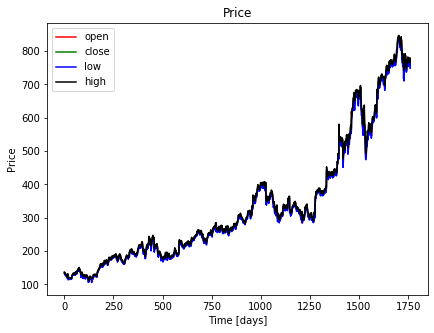

In [7]:
plot_variables(df)

In [8]:
def stationary_data(data, columns):
    satationary_df = data.copy()
    
    for column in columns:
        satationary_df[column] = np.log(satationary_df[column]) - np.log(satationary_df[column]).shift(1)

    satationary_df.dropna()
    
    return satationary_df

In [9]:
satationary_df = stationary_data(df, ["open", "adj_close", "low", "high", "volume"])
satationary_df.describe()

,open,low,high,volume,adj_close
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,0.000981,0.000980,0.000980,-0.000347,0.000978
std,0.020432,0.019296,0.018137,0.375122,0.020324
min,-0.158147,-0.139335,-0.140989,-1.564264,-0.135325
25%,-0.008883,-0.007533,-0.007383,-0.231667,-0.009201
50%,0.000782,0.001515,0.000162,-0.027677,0.000577
75%,0.011384,0.009653,0.008987,0.206599,0.012175
max,0.163498,0.131833,0.166223,1.439482,0.146225


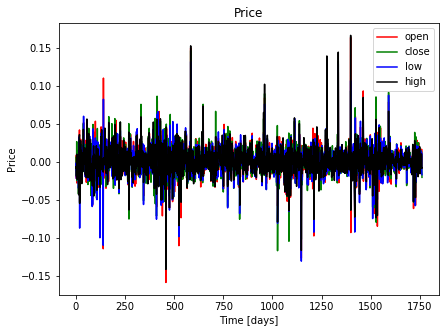

In [10]:
plot_variables(satationary_df)

In [11]:
def split_data(data):
    total_length = len(data)
    train_index = round(0.8 * total_length)
    
    train = data[:int(train_index), :]
    test = data[int(train_index):, :]
    
    return train, test

In [12]:
def normalize_data(train, test):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    train = min_max_scaler.fit_transform(train)
    test = min_max_scaler.transform(test)
    joblib.dump(min_max_scaler, "./data/min_max_scaler.pkl")
    
    return train, test

In [13]:
def formate_data(data, amount_of_features, seq_len):
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    
    x = result[:, :-1] 
    x = np.reshape(x, (x.shape[0], x.shape[1], amount_of_features))
    y = result[:, -1][:,-1] 

    return x, y

In [14]:
amount_of_features = len(df.columns)
seq_len = 30

train, test = split_data(df.values)
train, test = normalize_data(train, test)

x_train, y_train = formate_data(train, amount_of_features, seq_len)
x_test, y_test = formate_data(test, amount_of_features, seq_len)

print("Train set examples (x): ", x_train.shape[0])
print("Train set examples (y): ", y_train.shape[0])

print("Test set examples (x): ", x_test.shape[0])
print("Test set examples (y): ", y_test.shape[0])


Train set examples (x):  1379
Train set examples (y):  1379
Test set examples (x):  321
Test set examples (y):  321


In [30]:
def build_gru_model(amount_of_features, seq_len):
        
    model = Sequential()

    model.add(GRU(
        units=256,
        activation="tanh",
        return_sequences=True,
        dropout=0.2,
        input_shape=(seq_len, amount_of_features)
        )
    )

    model.add(GRU(
        units=256,
        activation="tanh",
        return_sequences=False,
        dropout=0.2
        )
    )

    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))

    model.summary()

    model.compile(
        optimizer="Nadam",
        loss="mse"
    )

    return model

In [31]:
model = build_gru_model(amount_of_features, seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30, 256)           201216    
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 611,713
Trainable params: 611,713
Non-trainable params: 0
_________________________________________________________________


In [32]:
def train_model(
    model, 
    x_train, 
    y_train,
    batch_size,
    epochs, 
    path
):
    
    history = model.fit(
        x=x_train, 
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        shuffle=False
    )
    # Once finished the training the model it will be saved and we will delete
    # the class attribute from memory.
    model.save(path)
    del model

    return history

In [33]:
epochs = 80
batch_size = 512

In [34]:
history = train_model(
    model, 
    x_train, 
    y_train, 
    batch_size,
    epochs, 
    "./data/gru-model")

Train on 1241 samples, validate on 138 samples
Epoch 1/80
1241/1241 [==============================] - 20s 16ms/sample - loss: 0.2576 - val_loss: 0.0056
Epoch 2/80
1241/1241 [==============================] - 8s 7ms/sample - loss: 0.1115 - val_loss: 0.0486
Epoch 3/80
1241/1241 [==============================] - 8s 7ms/sample - loss: 0.0483 - val_loss: 0.0051
Epoch 4/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0184 - val_loss: 0.0070
Epoch 5/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0191 - val_loss: 0.0067
Epoch 6/80
1241/1241 [==============================] - 8s 7ms/sample - loss: 0.0144 - val_loss: 0.0058
Epoch 7/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0170 - val_loss: 0.0056
Epoch 8/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0132 - val_loss: 0.0047
Epoch 9/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0104 - val_loss: 0.0051
Epoch 10/80
124

1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0023 - val_loss: 0.0057
Epoch 79/80
1241/1241 [==============================] - 9s 7ms/sample - loss: 0.0022 - val_loss: 0.0095
Epoch 80/80
1241/1241 [==============================] - 10s 8ms/sample - loss: 0.0028 - val_loss: 0.0038


In [35]:
def plot_model_loss(history):
    plt.figure(figsize=(25, 13))
    plt.subplot(311)
    plt.plot(history.epoch, history.history["loss"])
    plt.plot(history.epoch, history.history["val_loss"])
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.title("Model Behaviour")
    plt.legend(["loss", "val_loss"])
    

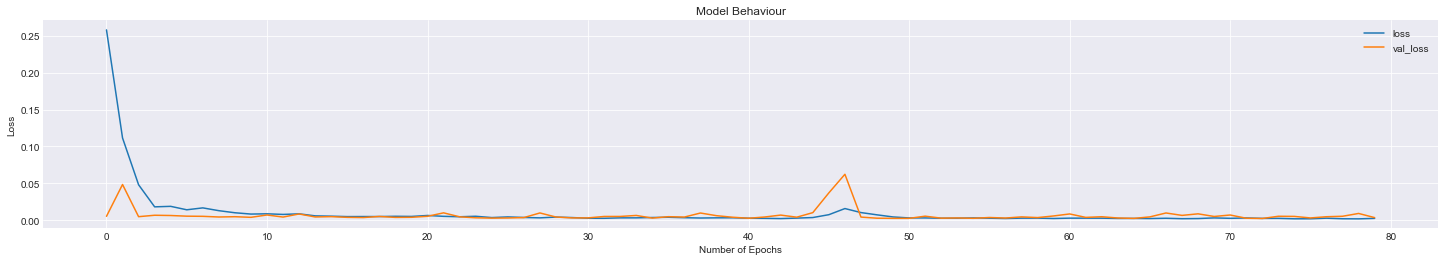

In [36]:
plot_model_loss(history)

In [37]:
model = load_model("./data/gru-model")

In [38]:
predictions = model.predict(x_test)

In [39]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

Train Score: 0.01219 MSE (0.11 RMSE)


In [40]:
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.00672 MSE (0.08 RMSE)


In [41]:
def plot_results_against_true_data(tested_data, true_data):
    plt.figure(figsize = (15,6))
    # style
    plt.style.use('seaborn-darkgrid')
    # create a color palette
    palette = plt.get_cmap('Set1')
    plt.plot(
        range(len(tested_data)), 
        tested_data, 
        marker='', 
        color="blue", 
        linewidth=0.5, 
        alpha=1, 
        label="Predicted Data"
    )

    plt.plot(
        range(len(true_data)), 
        true_data, 
        marker='', 
        color="black", 
        linewidth=0.5, 
        alpha=0.3, 
        label="Real Data"
    )

    plt.legend(loc=2, ncol=2)
    plt.title("Results comparison", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Hours")
    plt.ylabel("Price")
    plt.show()

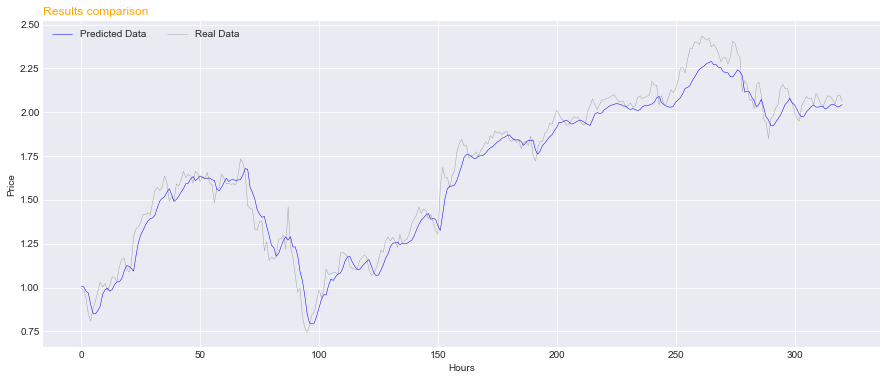

In [42]:
plot_results_against_true_data(predictions, y_test)